## **Project Report**

#### **🌟 The Key Findings & Results**: 
- **Achieved a 0.88-0.89/1 AUC (top 1% Kaggle competition leaderboard).**

- **Increased the Recall metric from 55% to 84%.** This means for every 100 customers who will churn, the model will correctly identify 84 of them, increasing the chance to keep the customer to stay. 

- **Visualize decision-making process with decision tree graph**, showing how the model makes step-by-step decisions (model interpretability). 

- **Quantify the the most significant factors of customer churn prediction**, which are *the number of products used by customers, the customer's active member status, and customer's geographic location.*

In [59]:
print(f'Recall of baseline model: {baseline_recall.round(2)}')
print(f'Recall of optimized model: {opt_recall.round(2)}')

print('The AUC-ROC score of the baseline model: ', roc_auc_score(y_test, y_pred_proba).round(2))
print('The AUC-ROC score of the optimized model: ', roc_auc_score(y_test, y_pred_proba2).round(2))

Recall of baseline model: 0.55
Recall of optimized model: 0.84
The AUC-ROC score of the baseline model:  0.88
The AUC-ROC score of the optimized model:  0.89


#### **📈 The Key Findings & Results**: 


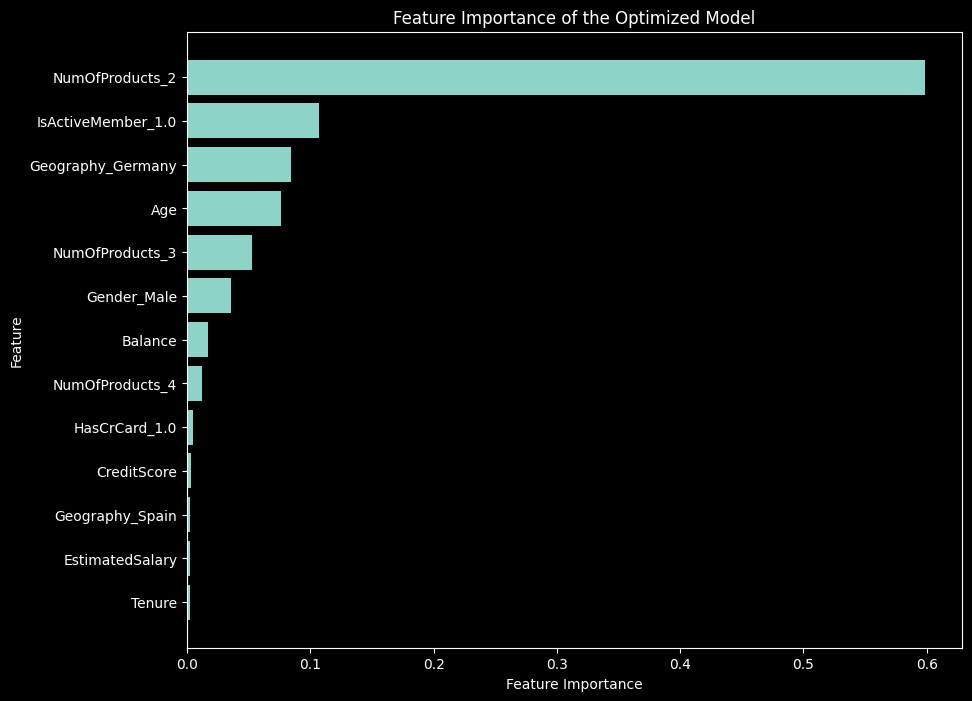

In [60]:
from IPython.display import Image
Image("../resources/results/feat_imp.png")

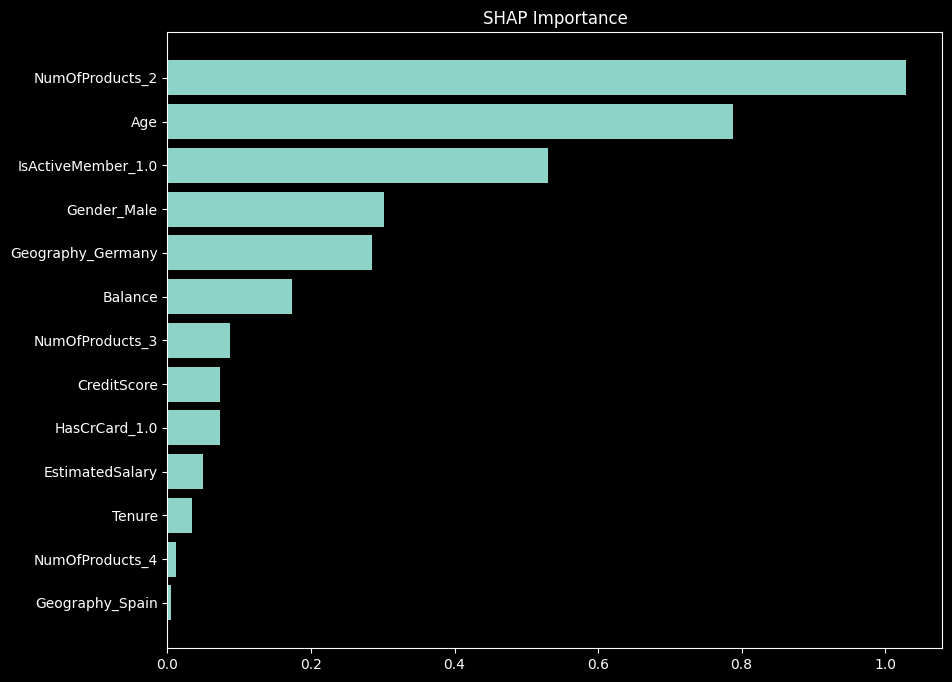

In [61]:
Image("../resources/results/shap_imp.png")

*Note: To run this notebook without error and render the report above, please run all the code below this cell first*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# import data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
submission_df = pd.read_csv('../data/sample_submission.csv')

## Data Preparation for model training

In [3]:
cols_to_drop = ['id', 'CustomerId', 'Surname']
X = train_df.drop(cols_to_drop, axis=1).copy()
X.drop('Exited', axis=1, inplace=True)
y = train_df['Exited'].copy()

### 1. One Hot Encoding Categorical Variables: 

In [4]:
dummies_col = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

X = pd.get_dummies(X, columns=dummies_col, drop_first=True)
X.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0
0,668,33.0,3,0.00,181449.97,False,False,True,True,False,False,True,False
1,627,33.0,1,0.00,49503.50,False,False,True,True,False,False,True,True
2,678,40.0,10,0.00,184866.69,False,False,True,True,False,False,True,False
3,581,34.0,2,148882.54,84560.88,False,False,True,False,False,False,True,True
4,716,33.0,5,0.00,15068.83,False,True,True,True,False,False,True,True


In [5]:
# Checking the ratio of the target variable
y.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

The distribution of target label (0 and 1) are highly imbalanced: almost 80% of the data is of label 0 (non-exited), label 1 only accounts for ~20%. 

### 2. Train-split dataset

In [6]:
# Splitting Data into Train and Test:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1, 
                                                    stratify=y)
# Checking the ratio of the label after splitting into train and test: 
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64
Exited
0    0.78841
1    0.21159
Name: proportion, dtype: float64


## Model Training

### 1. Creating Baseline Model: 

In [ ]:
# Building base line model
xgb_1 = XGBClassifier(objective='binary:logistic', 
                      seed=1)
xgb_1.fit(X_train, y_train, verbose=True, 
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

In [28]:
# Get all evaluation metrics on the test set
y_pred = xgb_1.predict(X_test)
# Get the AUC-ROC curve
y_pred_proba = xgb_1.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
print('The AUC-ROC score is: ', roc_auc_score(y_test, y_pred_proba))
conf_matrix_baseline = confusion_matrix(y_test, y_pred)

The AUC-ROC score is:  0.8840714728177874


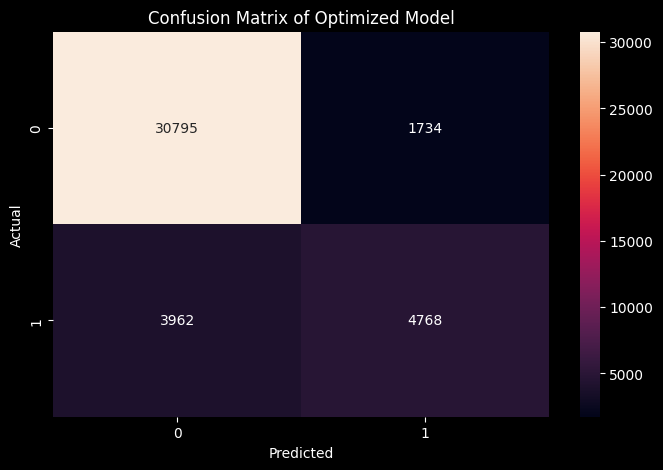

In [27]:
# Plotting the confusion matrix of the baseline model
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Baseline Model')
plt.show()

Some initial conclusions for **the baseline model** (Note: we define 0 is negative/non-churn and 1 is positive/churn): 
- We have a relatively high False Negative value: 3962. This value means in all the actual churn customer, we missed to capture 3962 customers. Our goal is to minimize this number. 

Next, there are some business-centric measures that is crucial in churn evaluation problem: 
- **False Negative (FN)** is an important measure for churn problem, defined as the group of customers identified as non-churn but is actually churn. Ideally, the model should minimize the FN number.

- **Recall $= \frac{{TP}}{FN + TP}$**: defined as out of all **actually churn customers**, what is the percentage of churn customers the model can capture. In this baseline model, Recall = 0.55. The goal is to improve the recall.

- **The AUC-ROC score**: This metric provides a comprehensive measure of the model's ability to discriminate between the positive (churn customers) and negative (non-churn customers) groups. The baseline score is 0.88/1. 

### 2. Model Hyperparameter Tuning and Cross-Validation: 

- Since the dataset is imbalanced with more negative-label data than positive-label data, we could use `scale_pos_weight` to deal with the imbalance

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 0.5, 1.0, 10.0],
    'gamma': [0, 0.25, 1.0],
    'scale_pos_weight': [1, 3, 5]
}

opt_param = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                seed=1,
                                                subsample=0.9,
                                                colsample_bytree=0.5),
                        param_grid=xgb_param_grid,
                        scoring='roc_auc',
                        verbose=3,
                        n_jobs=10,
                        cv=3)
opt_param.fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)],
                verbose=True) 

In [11]:
print('Best parameters found: ')
print(opt_param.best_params_)

Best parameters found: 
{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [ ]:
# Get all evaluation metrics on the test set
opt_xgb = XGBClassifier(objective='binary:logistic',
                        seed=1,
                        max_depth=5,
                        learning_rate=0.1,
                        reg_lambda=10.0,
                        gamma=0.25,
                        scale_pos_weight=5, 
                        subsample=0.9,
                        colsample_bytree=0.5)
opt_xgb.fit(X_train, y_train, 
            verbose=False, 
            early_stopping_rounds=40, 
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

y_pred2 = opt_xgb.predict(X_test)
conf_matrix_opt = confusion_matrix(y_test, y_pred2)

In [33]:
# Compute Recall for baseline model:
baseline_recall = conf_matrix_baseline[1,1]/(conf_matrix_baseline[1,0] + conf_matrix_baseline[1,1])
print(f'Recall of baseline model: {baseline_recall.round(2)}')

# Compute Recall for optimized model:
opt_recall = conf_matrix_opt[1,1]/(conf_matrix_opt[1,0] + conf_matrix_opt[1,1])
print(f'Recall of optimized model: {opt_recall.round(2)}')

# Compute the AUC-ROC score for the baseline model:
print('The AUC-ROC score of the baseline model: ', roc_auc_score(y_test, y_pred_proba).round(2))

# Compute the AUC-ROC score for the optimized model:
y_pred_proba2 = opt_xgb.predict_proba(X_test)[:,1]
print('The AUC-ROC score of the optimized model: ', roc_auc_score(y_test, y_pred_proba2).round(2))


Recall of baseline model: 0.55
Recall of optimized model: 0.84
The AUC-ROC score of the baseline model:  0.88
The AUC-ROC score of the optimized model:  0.89


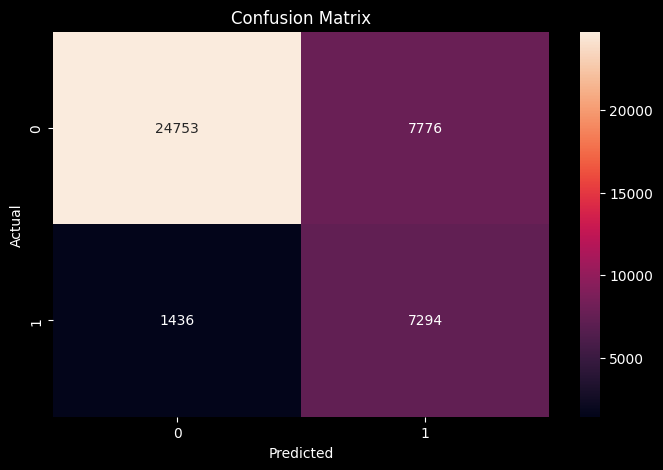

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_opt, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Optimized Model')
plt.show()

We can draw some initial conclusions for **the optimized model** using some business-centric measures:
- We increased the Recall metric from 55% to 84% by lowering the False Negative from 3962 to 1436 (-175%). This means for every 100 customers who will churn, the model will correctly identify 84 of them, increasing the chance to keep the customer to stay.

- However, we increased False Positive (identify customer who does not churn as churn) from 1734 to 7776 (+348%). This can cause inefficient cost spending on retaining promotion to customers who are not churning. Which leads to the next counter-balance metric to Recall, Precision $= \frac{TP}{TP+FP}$. 

- The Precision of the optimized model decreased from 73% to 48%. The Precision measures how often the model is correct when predicting a churn customer.

- Depending on which is more expensive, keeping an existing customer who is about to churn or giving too much promotion to customers who will not likely to churn, the business can decide to maximize Recall or Precision when facing the Precision-Recall tradeoff. 

## Decision-Making and Feature Importance Visualization 

### 1. Decision Tree: 

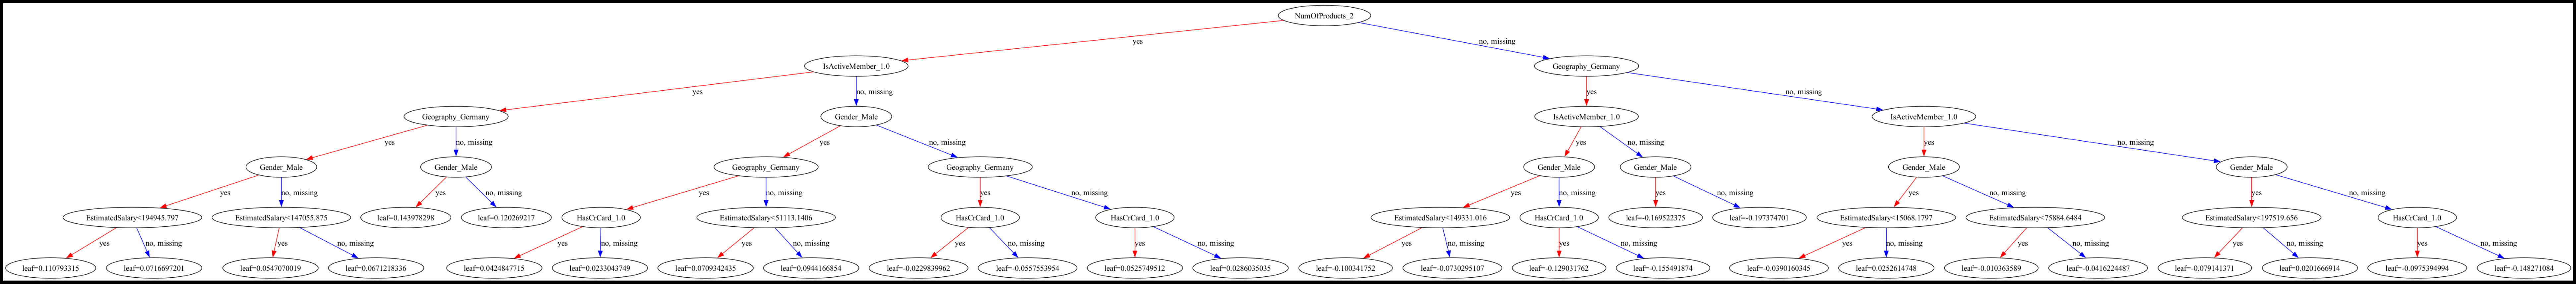

In [45]:
# Visualize the decision tree
plt.figure(figsize=(100, 100))
plot_tree(opt_xgb, num_trees=0, ax=plt.gca())
plt.show()

### 2. Feature Importance

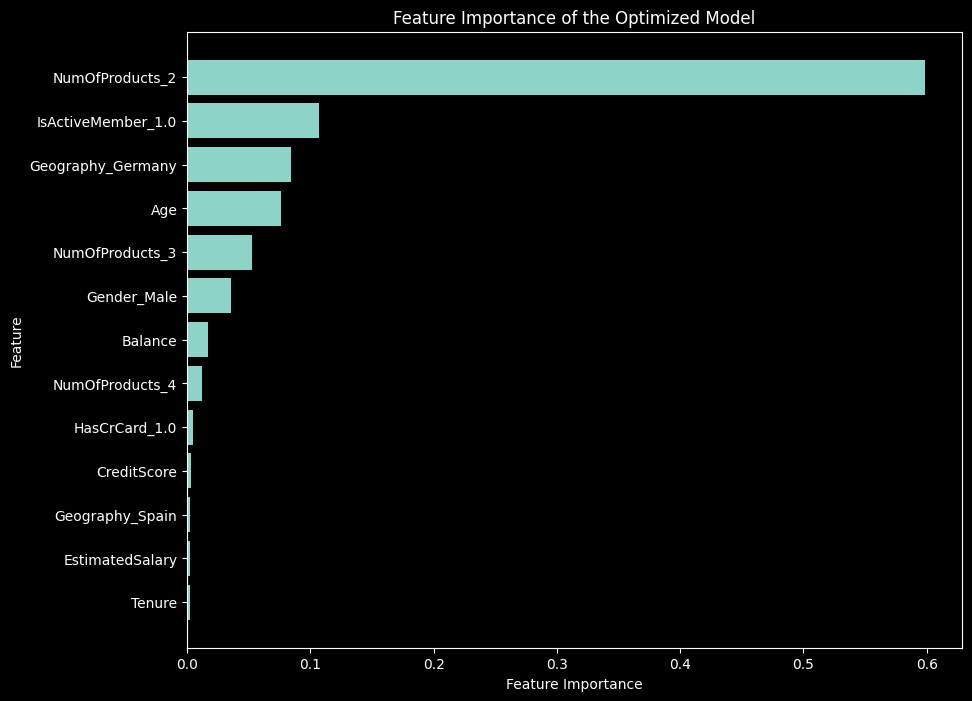

In [52]:
# Plot the feature importance of the optimized model
feature_importance = opt_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Optimized Model')
plt.show()


In this 

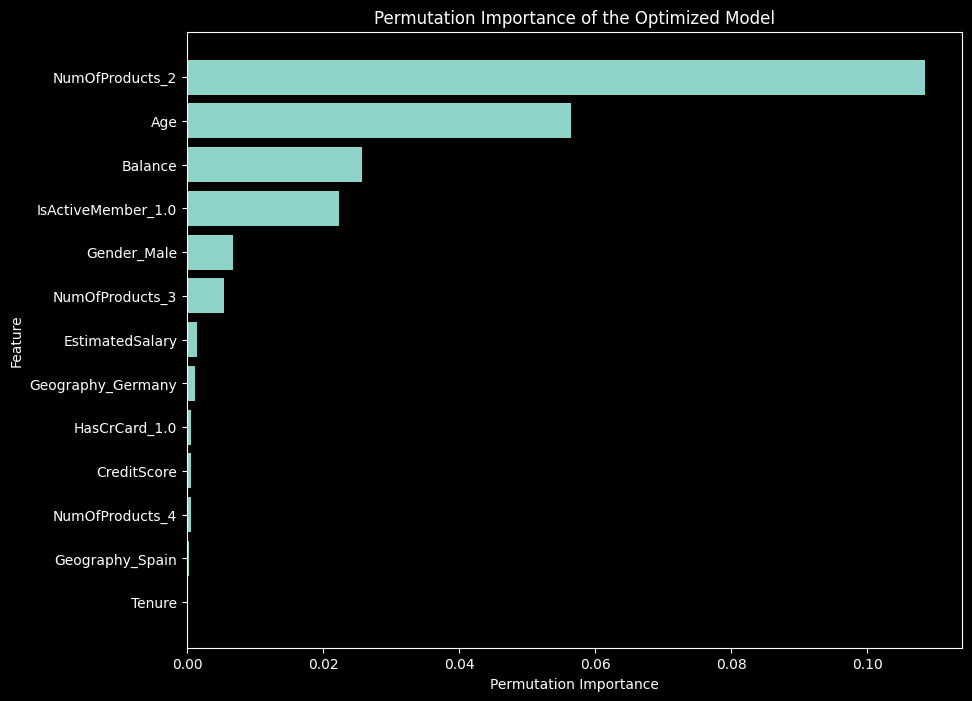

In [53]:
# Plot the Permutation Importance of the optimized model
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(opt_xgb, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance of the Optimized Model')
plt.show()


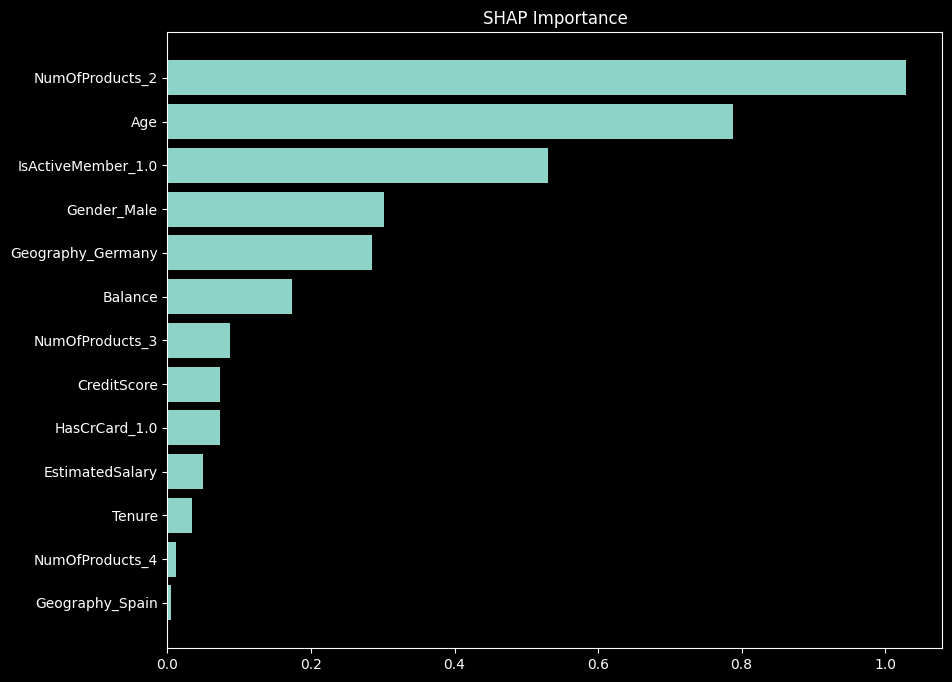

In [57]:
# Plot the SHAP importance of the optimized model
import shap

explainer = shap.Explainer(opt_xgb)
shap_values = explainer(np.ascontiguousarray(X_test))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')
plt.show()